# Case 3: Reform with and without Behavioral Effects

In [13]:
## Load libraries
import os
import pandas as pd

# Import shared helpers and TaxSolver components
from case_helpers import (
    tx, DataLoader, BracketInput,
    BudgetConstraint, IncomeConstraint, MarginalPressureConstraint, BracketConstraint,
    BudgetObjective, GurobiBackend,
    get_marginal_rate, calculate_tax, get_sq_marginal_rate_case1,
    load_simple_simul_data, filter_low_income_households,
)


In [14]:
## Load data
file_path = os.path.join('data', 'simple_simul_1000.xlsx')
df_taxpayers = pd.read_excel(file_path)
df_taxpayers['tax'] = df_taxpayers['income_before_tax'] - df_taxpayers['outcome_1']
df_taxpayers['hh_id'] = df_taxpayers.index

# Add marginal_rate_current to the data using shared helper
df_taxpayers['marginal_rate_current'] = df_taxpayers['income_before_tax'].apply(get_sq_marginal_rate_case1)

## Original reform without Behavioral Effects


In [15]:
dl = DataLoader(path=df_taxpayers, income_before_tax="income_before_tax", income_after_tax="outcome_1")

# Initialize the model WITHOUT behavioral effects
tax_solver = tx.TaxSolver(
    dl.households,
    backend=GurobiBackend(),
    behavioral_effects=False
)

# Define inflection points for bracket structure
inflection_points = [0, 25_000, 50_000, 75_000, 100_000, 1_000_000]

BracketInput.add_split_variables_to_solver(
    tx=tax_solver,
    target_var="income_before_tax",
    inflection_points=inflection_points,
    group_vars=["k_everybody"],
)

# Define rules with rate_lb=0
income_tax = tx.BracketRule(
    name="income_before_tax_k_everybody",
    var_name="income_before_tax",
    k_group_var="k_everybody",
    ub=1,
    lb=0,
)

tax_solver.add_rules([income_tax])

# Add constraints
# All households: 10% income loss limit
income_constraint = IncomeConstraint(0.10, dl.households.values())

# Household group <70k: must gain at least 5%
low_income_households = [
    hh for hh in dl.households.values() 
    if hh.members[0]["income_before_tax"] < 70_000
]
income_constraint_low_income = IncomeConstraint(-0.05, low_income_households)

# Budget constraint
budget_constraint_no_be = BudgetConstraint(
    "All_households", dl.households.values(), 1_000
)

# Marginal pressure constraint
marginal_pressure_constraint = MarginalPressureConstraint(1.0)

tax_solver.add_constraints([
    income_constraint, 
    income_constraint_low_income,
    budget_constraint_no_be, 
    marginal_pressure_constraint
])

# Create BracketConstraint for ascending rates
bracket_constraint = BracketConstraint(
    rule_family="income_before_tax_k_everybody",
    max_brackets=None,
    ascending=True,
    start_from_first_inflection=False,
    last_bracket_zero=False,
)
bracket_constraint.brackets = income_tax.flat_rules
tax_solver.add_constraints([bracket_constraint])

# Add objective
objective = BudgetObjective(budget_constraint_no_be)
tax_solver.add_objective(objective)

# Solve the system
tax_solver.solve()

# Get results
r_and_r_no_behavioral = tax_solver.rules_and_rates_table()
r_and_r_no_behavioral


Directly loading from pd.DataFrame...
Setting 'weight' to 1 as default.
Mirror household were missing for 1000 households: set to own id
Current tax balance All_households: -19991111
New Maximum: -19990111
Going to solve!
Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (mac64[arm] - Darwin 24.6.0 24G419)

CPU model: Apple M4 Max
Thread count: 16 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 4433 rows, 1013 columns and 6388 nonzeros
Model fingerprint: 0xf33f9421
Model has 6 simple general constraints
  1 MAX, 5 INDICATOR
Variable types: 1008 continuous, 5 integer (5 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+07]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+07]
  GenCon coe range [1e+00, 1e+00]
Presolve removed 3582 rows and 1008 columns
Presolve time: 0.00s
Presolved: 851 rows, 5 columns, 3244 nonzeros
Variable types: 5 continuous, 0 integer (0 binary)

Root relaxation: object

,rule_name,rule_type,var_name,rate,b,weight
0,income_before_tax_k_everybody__income_before_t...,FlatTaxRule,income_before_tax_k_everybody_0_25000,0.054955,1,1
1,income_before_tax_k_everybody__income_before_t...,FlatTaxRule,income_before_tax_k_everybody_25000_50000,0.160024,1,1
2,income_before_tax_k_everybody__income_before_t...,FlatTaxRule,income_before_tax_k_everybody_50000_75000,0.265000,1,1
3,income_before_tax_k_everybody__income_before_t...,FlatTaxRule,income_before_tax_k_everybody_75000_100000,0.640065,1,1
4,income_before_tax_k_everybody__income_before_t...,FlatTaxRule,income_before_tax_k_everybody_100000_1000000,0.640065,1,1


## Pareto Curve: Optimized Rate Schedules with Fixed Budget

For each elasticity level, we solve the optimization problem with:
- Fixed budget constraint (must collect exactly ~20M in taxes)
- Behavioral effects included in the model

This shows how optimal tax rates change when behavioral responses are accounted for.


In [ ]:
# Elasticity values to test
elasticities_to_test = [0, 0.005, 0.05]

# Store results for each elasticity
all_results = {}

# Target budget: approximately 20 million (matching the no-behavioral-effects result)
TARGET_BUDGET = 20_000_000
BUDGET_SLACK = 100_000  # Allow small deviation

for elasticity in elasticities_to_test:
    print(f"\n{'='*60}")
    print(f"Solving with elasticity = {elasticity}")
    print('='*60)
    
    # Reload data fresh for each solve
    dl_opt = DataLoader(path=df_taxpayers, income_before_tax="income_before_tax", income_after_tax="outcome_1")
    
    # Initialize the model with behavioral effects
    tax_solver_opt = tx.TaxSolver(
        dl_opt.households, 
        backend=GurobiBackend(),
        behavioral_effects=(elasticity > 0),  # Only enable if elasticity > 0
        behavioral_elasticity=elasticity if elasticity > 0 else None
    )
    
    # Define inflection points
    inflection_points = [0, 25_000, 50_000, 75_000, 100_000, 1_000_000]
    
    BracketInput.add_split_variables_to_solver(
        tx=tax_solver_opt,
        target_var="income_before_tax",
        inflection_points=inflection_points,
        group_vars=["k_everybody"],
    )
    
    # Define rules
    income_tax = tx.BracketRule(
        name="income_before_tax_k_everybody",
        var_name="income_before_tax",
        k_group_var="k_everybody",
        ub=1,
        lb=0,
    )
    
    tax_solver_opt.add_rules([income_tax])
    
    # Constraints
    income_constraint = IncomeConstraint(0.10, dl_opt.households.values())
    
    low_income_households = [
        hh for hh in dl_opt.households.values() 
        if hh.members[0]["income_before_tax"] < 70_000
    ]
    income_constraint_low_income = IncomeConstraint(-0.05, low_income_households)
    
    # Budget constraint: must collect approximately TARGET_BUDGET
    # Using both min and max to constrain to a narrow range
    budget_constraint_opt = BudgetConstraint(
        "All_households", 
        dl_opt.households.values(), 
        max_bln_mut_expenditure=BUDGET_SLACK,
        min_bln_mut_expenditure=-BUDGET_SLACK
    )
    
    marginal_pressure_constraint = MarginalPressureConstraint(1.0)
    
    tax_solver_opt.add_constraints([
        income_constraint, 
        income_constraint_low_income,
        budget_constraint_opt, 
        marginal_pressure_constraint
    ])
    
    # Ascending bracket constraint
    bracket_constraint = BracketConstraint(
        rule_family="income_before_tax_k_everybody",
        max_brackets=None,
        ascending=True,
        start_from_first_inflection=False,
        last_bracket_zero=False,
    )
    bracket_constraint.brackets = income_tax.flat_rules
    tax_solver_opt.add_constraints([bracket_constraint])
    
    # Objective
    objective = BudgetObjective(budget_constraint_opt)
    tax_solver_opt.add_objective(objective)
    
    # Solve
    tax_solver_opt.solve()
    
    # Store results
    rates_df = tax_solver_opt.rules_and_rates_table()
    tax_revenue = -tax_solver_opt.backend.get_value(budget_constraint_opt.new_expenditures)
    
    all_results[elasticity] = {
        'rates': rates_df,
        'tax_revenue': tax_revenue,
        'solver': tax_solver_opt
    }


Solving with elasticity = 0
Directly loading from pd.DataFrame...
Using 'income_after_tax' as the income before tax column.
Mirror household were missing for 1000 households: set to own id
Current tax balance All_households: -19991111
New Maximum: -19891111
New Minimum: -20091111
Going to solve!
Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (mac64[arm] - Darwin 24.6.0 24G419)

CPU model: Apple M4 Max
Thread count: 16 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 4434 rows, 1013 columns and 6389 nonzeros
Model fingerprint: 0x68cb4c87
Model has 6 simple general constraints
  1 MAX, 5 INDICATOR
Variable types: 1008 continuous, 5 integer (5 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+07]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+07]
  GenCon coe range [1e+00, 1e+00]
Presolve removed 3583 rows and 1007 columns
Presolve time: 0.00s
Presolved: 851 rows, 6 columns, 3245 nonzeros

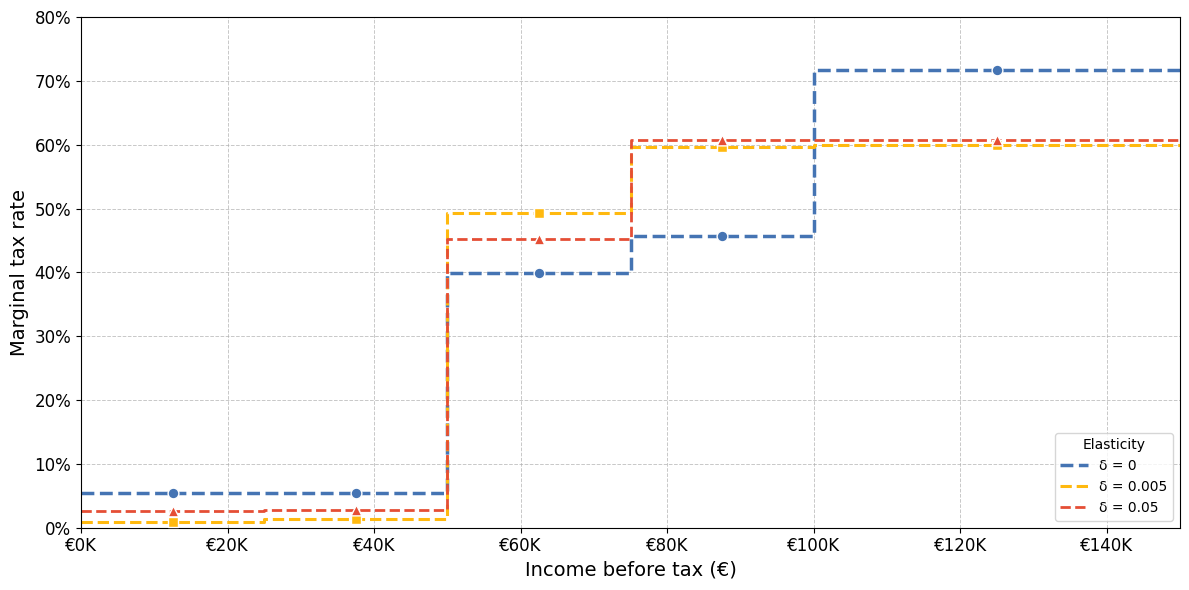

In [ ]:
# Helper functions and configuration for plots
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

# Import shared plotting helpers
from case_helpers import euro_format, euro_format_full, wrangle_intervals, build_tax_line

# Visualize rate schedules as step functions
fig, ax = plt.subplots(figsize=(12, 6))

# Define the bracket boundaries (inflection points used in optimization)
bracket_boundaries = [0, 25_000, 50_000, 75_000, 100_000, 150_000]  # Cap at 150K for display

# Use RdYlBu colormap colors (blue to red progression)
cmap = plt.cm.RdYlBu
colors = [cmap(0.9), '#FFB90F', cmap(0.15), '#8B0000']  # Blue to darkred progression
markers = ['o', 's', '^', 'D']
line_widths = [2.5, 2.2, 2.0, 1.8]

for i, elasticity in enumerate(elasticities_to_test):
    if elasticity in all_results and all_results[elasticity] is not None:
        rates = all_results[elasticity]['rates']['rate'].values
        
        # Create step function data points
        x_step = []
        y_step = []
        x_markers = []  # For placing markers at bracket boundaries
        y_markers = []
        
        for j, rate in enumerate(rates):
            lower = bracket_boundaries[j]
            upper = bracket_boundaries[j + 1] if j + 1 < len(bracket_boundaries) else 150_000
            
            # Cap at 150K
            if lower >= 150_000:
                break
            upper = min(upper, 150_000)
            
            x_step.extend([lower, upper])
            y_step.extend([rate, rate])
            
            # Add marker at midpoint of each bracket
            x_markers.append((lower + upper) / 2)
            y_markers.append(rate)
        
        # Plot step function line
        ax.plot(x_step, y_step, 
                color=colors[i % len(colors)], 
                linestyle='--',
                linewidth=line_widths[i % len(line_widths)],
                label=f'δ = {elasticity}')
        
        # Add markers at bracket midpoints for visibility
        ax.scatter(x_markers, y_markers, 
                   color=colors[i % len(colors)], 
                   marker=markers[i % len(markers)],
                   s=60, zorder=5, edgecolors='white', linewidth=1)

ax.set_xlabel('Income before tax (€)', fontsize=14)
ax.set_ylabel('Marginal tax rate', fontsize=14)
ax.legend(title='Elasticity', loc='lower right')
ax.set_xlim(0, 150_000)
ax.set_ylim(0, 0.8)  # Adjust y-limit to focus on actual rate range
ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'€{x/1000:.0f}K'))
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.0%}'))
ax.tick_params(axis="x", labelsize=12)
ax.tick_params(axis="y", labelsize=12)
ax.grid(True, linestyle="--", linewidth=0.7, alpha=0.7)

plt.tight_layout()
plt.show()